In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from IPython.display import clear_output

tqdm.pandas()
pd.options.display.max_colwidth = -1
pd.options.display.max_columns = 25

In [3]:
from dsutils.eda import *
from dsutils.stats import *
from dsutils.ml import *

In [4]:
import pickle

In [5]:
cv = pickle.load(open('BinaryCountVectorizer.pkl', 'rb'))
tv = pickle.load(open('TfidfVectorizer.pkl', 'rb'))

In [6]:
data = pd.read_csv('fuzzy_features_clean.csv')

In [7]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,abs_token_diff,avg_num_token,rel_token_diff,token_intersection,token_union,jaccard_similarity_token,...,abs_word_diff,avg_num_word,rel_word_diff,word_intersection,word_union,jaccard_similarity_word,lcs_word,lcs_word_ratio,fuzz_simple_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,2,13.0,0.153846,10,13,0.769231,...,1,6.5,0.153846,5,6,0.833333,6,0.923077,92,98,92,100
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,5,10.5,0.476190,4,16,0.250000,...,5,7.5,0.666667,4,11,0.363636,4,0.533333,64,91,62,89
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,4,12.0,0.333333,3,21,0.142857,...,1,5.5,0.181818,3,8,0.375000,1,0.181818,66,67,71,85
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,2,10.0,0.200000,0,19,0.000000,...,4,7.0,0.571429,0,11,0.000000,0,0.000000,44,56,15,19
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,6,10.0,0.600000,2,18,0.111111,...,5,7.5,0.666667,2,13,0.153846,1,0.133333,52,64,42,53


In [8]:
data.dropna(inplace=True)

In [9]:
from scipy.spatial.distance import cosine
from scipy.sparse import hstack, vstack

In [10]:
q1_vect = tv.transform(data['q1_clean'])
q2_vect = tv.transform(data['q2_clean'])

# Model Fitting

In [11]:
vects1 = hstack([q1_vect, q2_vect])
vects2 = hstack([q2_vect, q1_vect])

vects = vstack([vects1, vects2]).tocsr()

In [12]:
target = np.concatenate([data['is_duplicate'].values, data['is_duplicate'].values])

In [13]:
print(vects.shape, target.shape)

(808248, 188784) (808248,)


In [14]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

Mean Loss 0.5322366017861965 +- 0.0015213433178632304


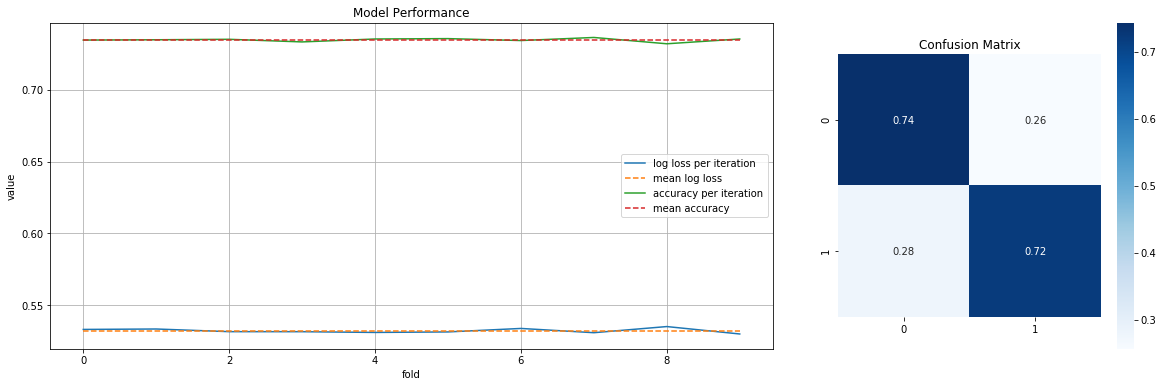

In [15]:
model = LogisticRegression(class_weight='balanced')
lr_performance, lr_cm, lr_model = train_model_on_vects(model, vects, target)
print('Mean Loss', np.mean(lr_performance['log loss']), '+-', np.std(lr_performance['log loss']))

Mean Loss 0.5301263803284154 +- 0.0015588960482416652


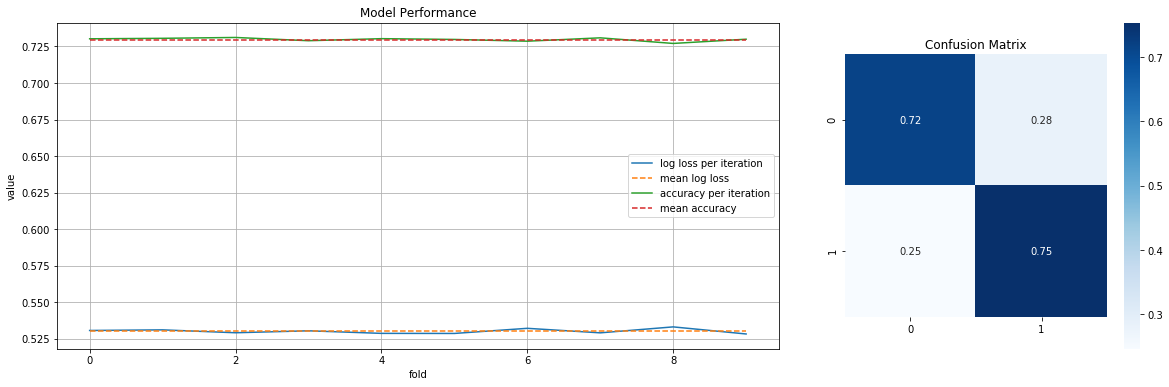

In [16]:
model = LogisticRegression(class_weight='balanced', C=10)
lr10_performance, lr10_cm, lr10_model = train_model_on_vects(model, vects, target)
print('Mean Loss', np.mean(lr10_performance['log loss']), '+-', np.std(lr10_performance['log loss']))

Mean Loss 0.5474748571917593 +- 0.0026821474341136263


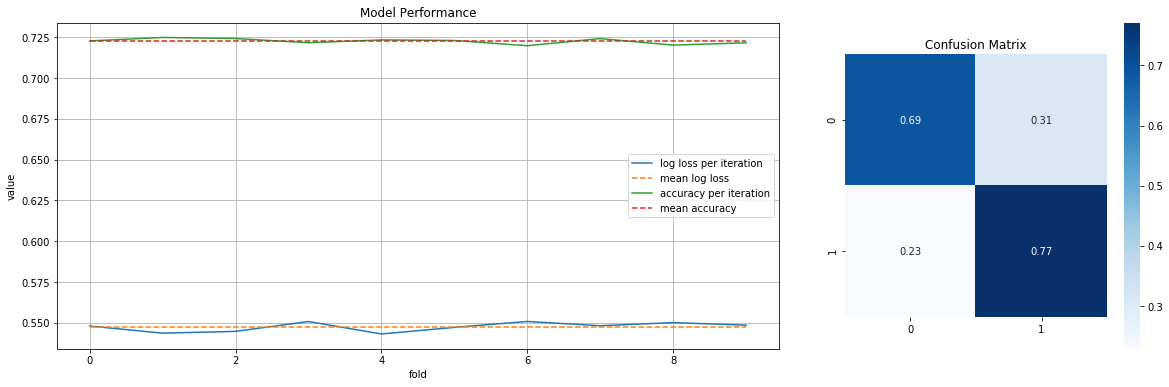

In [17]:
model = LogisticRegression(class_weight='balanced', C=100)
lr100_performance, lr100_cm, lr100_model = train_model_on_vects(model, vects, target)
print('Mean Loss', np.mean(lr100_performance['log loss']), '+-', np.std(lr100_performance['log loss']))

Mean Loss 0.5450411404253231 +- 0.0019345794314143208


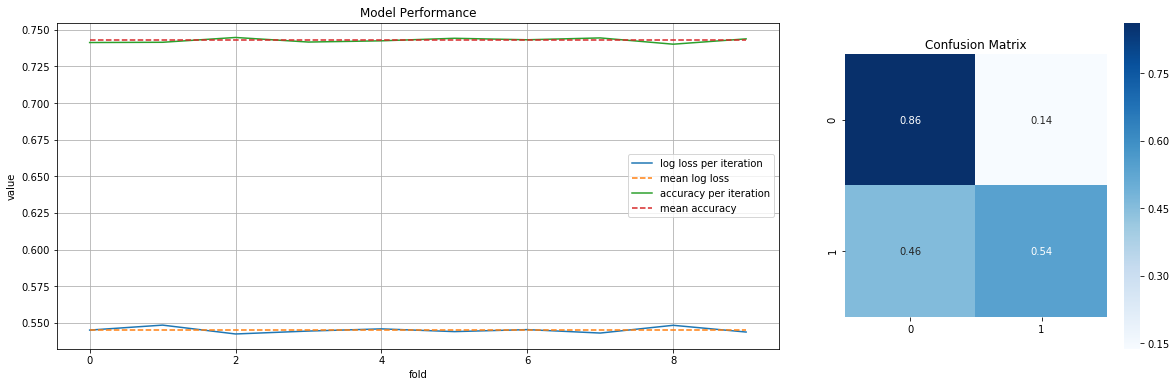

In [18]:
model = MultinomialNB()
mnb_performance, mnb_cm, mnb_model = train_model_on_vects(model, vects, target)
print('Mean Loss', np.mean(mnb_performance['log loss']), '+-', np.std(mnb_performance['log loss']))

Mean Loss 0.5543549669624533 +- 0.004218103345497953


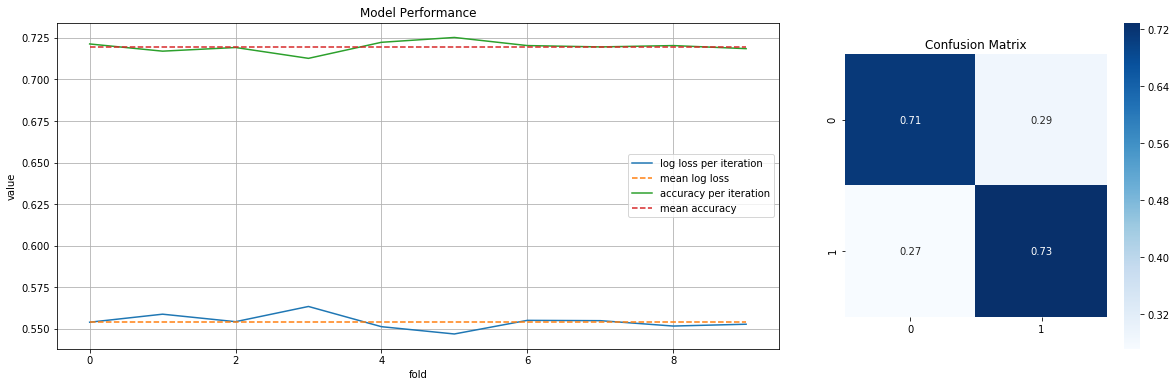

In [19]:
model = SGDClassifier(loss='log', class_weight='balanced', alpha=0.000001, early_stopping=True, warm_start=True, 
                      random_state=101)
sgd_performance, sgd_cm, sgd_model = train_model_on_vects(model, vects, target)
print('Mean Loss', np.mean(sgd_performance['log loss']), '+-', np.std(sgd_performance['log loss']))

Mean Loss 0.527864193013744 +- 0.0017530263770807594


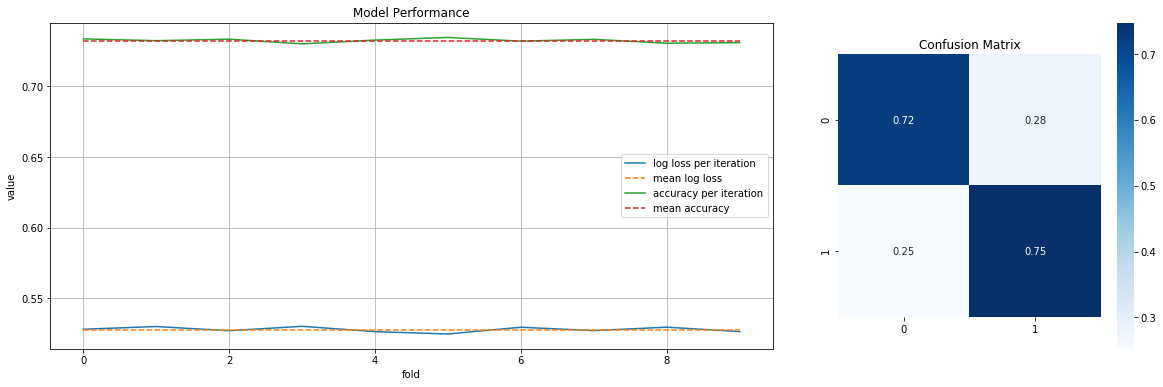

In [21]:
model = VotingClassifier(
    estimators=[('lr1', LogisticRegression(class_weight='balanced')), 
                ('lr10', LogisticRegression(class_weight='balanced', C=10)), 
                ('lr100', LogisticRegression(class_weight='balanced', C=100)), 
                ('sgd', SGDClassifier(loss='log', class_weight='balanced', alpha=0.000001, early_stopping=True, 
                                      warm_start=True, random_state=101))
               ],
    voting='soft',
)
vc_performance, vc_cm, vc_model = train_model_on_vects(model, vects, target)
print('Mean Loss', np.mean(vc_performance['log loss']), '+-', np.std(vc_performance['log loss']))

In [23]:
pickle.dump(vc_model, open('TFIDFVotingClassifier.pkl', 'wb'))